# Standard Counting Patterns

This notebook contains the standard precomputation steps for normal subgraph motif counting settings.

Simply choosing your setting via the respective `settings` module and running the notebook should be enough for everything to work (assuming the precomputations for that setting were performed previously). 


The host graphs are set in the `dfpaths` dictionary below.

Be warned that this may take a while on large patterns. Also the progress bar may seems stuck at certain percentages. This is likely because homomorphism counting is significantly more difficult on some graphs than others and the corresponding steps in the progress bar will therefore take longer.

In [1]:
%reload_ext rich


import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import dill
from pact.ui import default_progressbar
from pact.naive_exec import naive_pandas_homcount


from settings.treelets import *
K = 6

with open(spasm_filename(K), 'rb') as f:
    spasm_space = dill.loads(f.read())
    
with open(patterns_filename(K), 'rb') as f:
    patterns = dill.loads(f.read())


# Count all Patterns

In [2]:

def compute_sub_counts_for_df(base, patterns, progressbar_label=''):
    global spasm_space

    counts = {k: 0 for k in patterns.keys()}
    with default_progressbar() as progress:
        track = progress.track(spasm_space.graphs_iter(),
                               description=progressbar_label,
                               total=len(spasm_space))
        for G in track:
            homs = naive_pandas_homcount(G, base)
            for k, pattern in patterns.items():
                if G.id in pattern.hombase:
                    coeff = pattern.hombase[G.id]
                    add = coeff * int(homs)
                    counts[k] += add
                    
        # sanity check
        for pattern, c in counts.items():
            if c.denominator != 1:
                print('INSANE!', pid, c)

        countdf = pd.DataFrame(({'pattern': pid, '#Sub': round(c)} for pid, c in counts.items()))
        return countdf

def df_from_gml(gmlpath, directed):
    graph = nx.read_gml(gmlpath, label=None)

    graphdf = pd.DataFrame(({'s': a, 't': b} for a, b in graph.edges()))
    if not directed:
        graphdf = pd.concat([graphdf, pd.DataFrame(({'s': b, 't': a} for a, b in graph.edges()))])
    graphdf = graphdf.convert_dtypes()
    return graphdf.drop_duplicates().query('s != t')
    
def compute_sub_counts_from_gml(gmlpath, patterns, directed=False):
    graphdf = df_from_gml(gmlpath, directed)
    return compute_sub_counts_for_df(graphdf, patterns, progressbar_label=gmlpath)

directed = nx.is_directed(list(patterns.values())[0].graph)  # no support for mixed patterns

dfpaths = {
    'E.coli': 'data/host_graphs/examples/alon_ecoli.gml',
    'C.ele': 'data/host_graphs/examples/alon_celegans.gml',
    'S.cerev': 'data/host_graphs/examples/alon_yeast.gml',
    'H.pylo': 'data/host_graphs/examples/alon_hpylo.gml',
}

dfs = {name: compute_sub_counts_from_gml(path, patterns, directed)
       for name, path in dfpaths.items()}

Output()

Output()

Output()

Output()

# Count Analysis

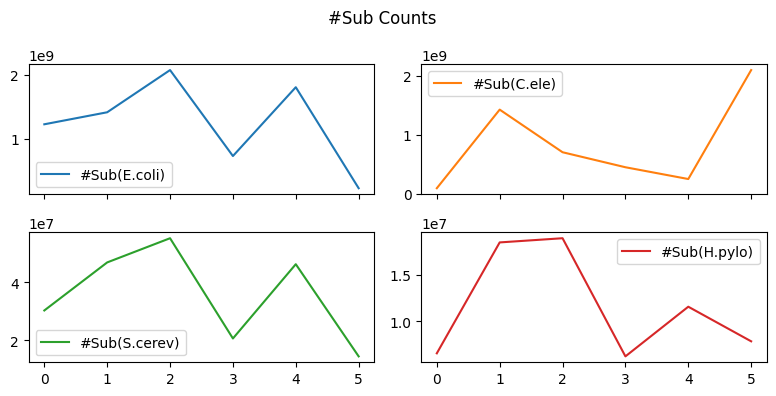

In [3]:

statdf = None
for name, countdf in dfs.items():
    cdf = countdf.rename(columns={'#Sub': f'#Sub({name})'})
    cdf[f'#Sub({name})'] = cdf[f'#Sub({name})'].apply(int)
    if statdf is None:
        statdf = cdf.copy()
    else:
        statdf = statdf.join(cdf.set_index('pattern'), on='pattern')
        
for col in statdf.columns:
    if '#Sub' not in col:
        continue
    #statdf[col] = 2
ax = statdf.plot(subplots=True, sharey=False,
                 figsize=(8, 4), layout=(2,2), 
                 legend=True, style={'legen.fontsize': 20})
plt.suptitle('#Sub Counts')
plt.tight_layout()

# Preparatory work on nice output reports

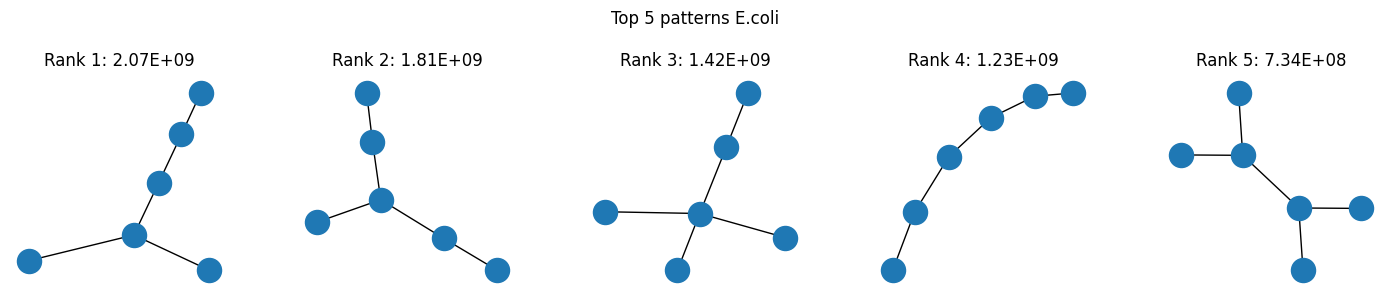

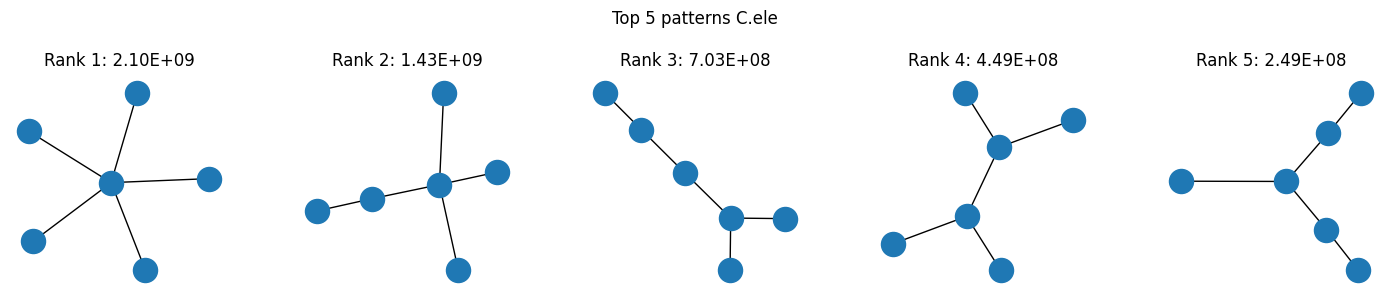

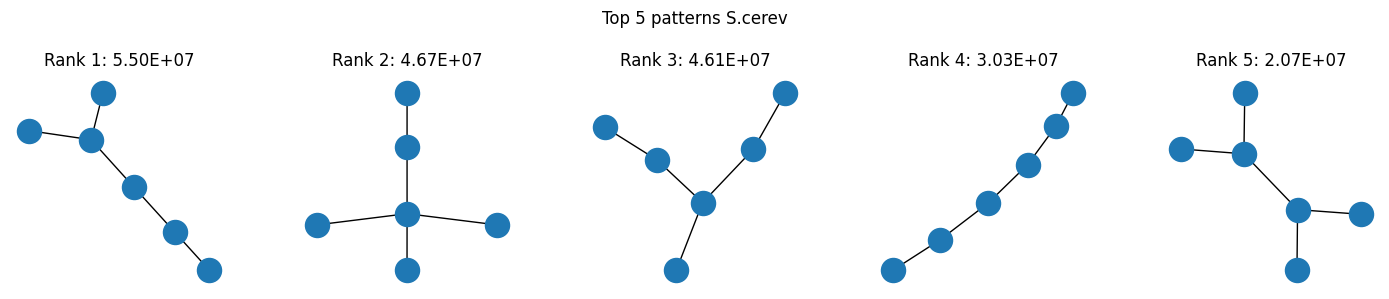

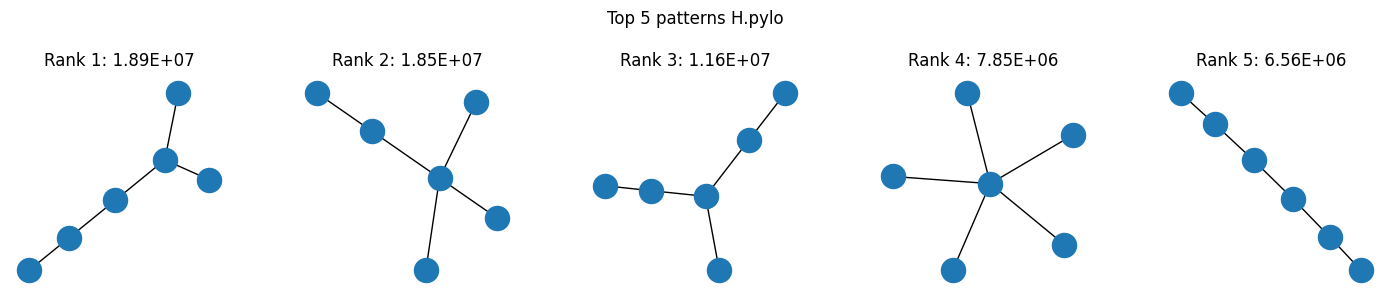

In [4]:
def draw_topn_patterns(df, n, name=''):
    analysisdf = df

    subcol = [c for c in df.columns if '#Sub' in c][0]
    fig = plt.figure(figsize=(3*n-1,3))
    fig.suptitle(f'Top {n} patterns {name}')
    gs = fig.add_gridspec(nrows=1, ncols=n)

    for i in range(n):
        ax1 = fig.add_subplot(gs[0, i])
        most = analysisdf.sort_values(subcol, ascending=False).iloc[i]
        c = int(most['#Sub'])
        nx.draw(patterns[most.pattern].graph)
        plt.title(f'Rank {i+1}: {c:.2E}')
    plt.tight_layout(w_pad=5)
    
for name, df in dfs.items():
    draw_topn_patterns(df, 5, name)